# Train the NV30 model using Google Colab

In [ ]:
import tensorflow as tf
from google.colab import drive, files
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
import pickle

# An imagevarigoram generator class


*   generates new images at the end of each epoch
*   returns either images `vgram=False` or vgrams `vgram=True`



In [ ]:
class ImageVariogramGenerator(tf.keras.utils.Sequence):
    def __init__(self, path_prefix, path_suffix='', batch_size=256, random_shuffle=True,
                 flip_transpose = True,
                 test=False, replicates=10,
                 multivario=True, vgrams = True,
                 scale_y=True, Scaler=StandardScaler,
                 new_data_every = 10,
                 verbose = True):
        ## load training parameter configurations
        self.Rin_chols = tf.convert_to_tensor(np.load(path_prefix + '_chols.npy' + path_suffix),
                                              dtype="float32")
        self.Rin_alphaMat = tf.convert_to_tensor(np.load(path_prefix + '_alphaMat.npy' + path_suffix),
                                                 dtype="float32")
        self.Rin_thetaGrid= tf.convert_to_tensor(np.load(path_prefix + '_thetaGrid.npy' + path_suffix),
                                                 dtype="float32")
        self.Rin_y = np.load(path_prefix + '_y.npy' + path_suffix)
        self.Rin_y = tf.convert_to_tensor(self.Rin_y, dtype="float32")
        ## scale y
        self.scale_y = scale_y
        self.Scaler = Scaler
        if self.scale_y:
            self.scaler_y = self.Scaler().fit(self.Rin_y)
            self.Rin_y = self.scaler_y.transform(self.Rin_y)

        self.m = replicates
        self.nObs = self.Rin_chols.shape[0]
        self.N = int(np.sqrt(self.nObs))
        self.nTheta = len(self.Rin_thetaGrid)
        self.nLambda = self.Rin_alphaMat.shape[0]
        self.nChunk = self.m * self.nLambda
        
        self.batch_size = batch_size
        self.random_shuffle = random_shuffle
        if vgrams and flip_transpose:
            self.flip_transpose = False
            tf.print("!! ignore 'flip_transpose = True' because 'vgrams = True'")
            self.vg, self.dist, self.w = None, None, None
        else:
            self.flip_transpose = flip_transpose
        self.test = test
        self.verbose = verbose

        self.multivario = multivario
        if multivario:
            self.vgrams = True
        else:
            self.vgrams = vgrams
        self.im, self.y = None, None
        self.epoch_counter = 0
        self.new_data_every = new_data_every
        self.on_epoch_end()

    def flip_transpose_fn(self):
        """ augment data by flipping and rotating the images""" 
        if self.verbose:
          tf.print(', add 7 flips/transposes, ', end='')
        r1 = tf.reverse(self.im, axis=[1])
        r2 = tf.reverse(self.im, axis=[2])
        r3 = tf.reverse(self.im, axis=[1,2])
        t0 = tf.transpose(self.im, perm=[0,2,1,3])
        t1 = tf.transpose(r1, perm=[0,2,1,3])
        t2 = tf.transpose(r2, perm=[0,2,1,3])
        t3 = tf.transpose(r3, perm=[0,2,1,3])
        self.im = tf.concat([self.im, r1, r2, r3, t0, t1, t2, t3], axis=0)
        self.y = tf.tile(self.y, [8,1])
        
    def generate_im(self, verbose=None):
        """simulate images from training parameter configurations"""
        if verbose is None:
            verbose = self.verbose
        if verbose:
            tf.print('generate data', end='')
        if self.test:
            normal = random_test(shape=[self.nTheta, self.nObs, self.nChunk, 2])
        else:
            normal = tf.random.normal(shape=[self.nTheta, self.nObs, self.nChunk, 2])
            
        bigG = tf.linalg.matmul(a=tf.transpose(self.Rin_chols, [2,0,1]),
                                b=normal[:,:,:,0]) 
        bigG = tf.reshape(bigG, [self.nTheta, self.nObs, self.nLambda, self.m])
        bigG = tf.transpose(bigG, [1,3,2,0])
        # bigG.shape: nObs, m, nLambda, nTheta
        
        # Rin_alphaMat.shape: nLambda, nTheta
        alphaArray = tf.reshape(self.Rin_alphaMat, [1, 1, self.nLambda, self.nTheta])
        alphaArray = tf.tile(alphaArray, [self.nObs, self.m, 1, 1])
        
        self.im = tf.sqrt(1-alphaArray) * bigG + \
            tf.sqrt(alphaArray) * tf.reshape(normal[:,:,:,1], alphaArray.shape)
        self.im = tf.reshape(self.im, [self.nObs, self.m*self.nLambda*self.nTheta])
        self.im = tf.reshape(tf.transpose(self.im), [self.m*self.nLambda*self.nTheta, self.N, self.N])
        self.im = tf.expand_dims(self.im, 3)
        
        # Rin_y: [lambda, theta]
        self.y = tf.reshape(self.Rin_y, [self.nTheta, self.nLambda, 2, 1])
        self.y = tf.transpose(self.y, [2, 3, 1, 0])
        self.y = tf.tile(self.y, [1, self.m, 1, 1])
        self.y = tf.transpose(tf.reshape(self.y, [2, self.m*self.nLambda*self.nTheta]))

    def squared_diff(self, i, im):
        """ compute the sqared difference when shifting image. Helper function for vgram()"""
        # self.x: input data with shape NHWC
        # i: int index to go out
        dist = np.sqrt(i**2 + np.arange(0,i+1)**2)
        if i == 1:
            ix = [[i, 0], [i, -i]]
            iy = [[0, i], [i,  i]]
        else:
            ix = [[i, k] for k in range(1,i)]
            ix.insert(0, [i, 0])
            ix.append([i, -i])
            iy = [[k, i] for k in range(1,i)]
            iy.insert(0, [0, i])
            iy.append([i, i])
        diff = []
        w = np.zeros(len(dist))
        for j in range(len(dist)):
            w[j] = (im.shape[1]-ix[j][0]) * (im.shape[2]-iy[j][0]) * 2
            if j == 0:
                tmp = [tf.expand_dims(
                    tf.reduce_sum(tf.math.squared_difference(im[:, ix[j][k]:, iy[j][k]:, :],
                                                             im[:, 0:(im.shape[1]-ix[j][k]), 0:(im.shape[2]-iy[j][k]), :]),
                                  axis=[1,2]), axis=2)
                       for k in range(2)]
                tmp = tf.expand_dims(tf.reduce_sum(tf.concat(tmp, axis=2), axis=2), axis=2)
            elif j == len(dist)-1:
                tmp1 = tf.expand_dims(
                    tf.reduce_sum(tf.math.squared_difference(im[:, ix[j][0]:, iy[j][0]:, :],
                                                             im[:, 0:(im.shape[1]-ix[j][0]), 0:(im.shape[2]-iy[j][0]), :]),
                                  axis=[1,2]), axis=2)
                tmp2 = tf.expand_dims(
                    tf.reduce_sum(tf.math.squared_difference(im[:, 0:(im.shape[1]-ix[j][0]), iy[j][0]:, :],
                                                             im[:, ix[j][0]:, 0:(im.shape[2]-iy[j][0]), :]),
                                  axis=[1,2]), axis=2)
                tmp = tf.expand_dims(tf.reduce_sum(tf.concat([tmp1, tmp2], axis=2), axis=2), axis=2)
            else:
                w[j] *= 2
                tmp1 = [tf.expand_dims(
                    tf.reduce_sum(tf.math.squared_difference(im[:, ix[j][k]:, iy[j][k]:, :],
                                                             im[:, 0:(im.shape[1]-ix[j][k]), 0:(im.shape[2]-iy[j][k]), :]),
                                  axis=[1,2]), axis=2)
                        for k in range(2)]
                tmp1 = tf.expand_dims(tf.reduce_sum(tf.concat(tmp1, axis=2), axis=2), axis=2)
                tmp2 = [tf.expand_dims( # x shifted in other direction ..
                    tf.reduce_sum(tf.math.squared_difference(im[:, 0:(im.shape[1]-ix[j][k]), iy[j][k]:, :],
                                                             im[:, ix[j][k]:, 0:(im.shape[2]-iy[j][k]), :]),
                                  axis=[1,2]), axis=2)
                        for k in range(2)]
                tmp2 = tf.expand_dims(tf.reduce_sum(tf.concat(tmp2, axis=2), axis=2), axis=2)
                tmp = tf.expand_dims(tf.reduce_sum(tf.concat([tmp1, tmp2], axis=2), axis=2), axis=2)
            diff.append(tmp / w[j])
        diff = tf.concat(diff, axis=2)
        return diff, dist, w

    def vgram(self, im=None, verbose=None):
      """compute variograms from images"""
        if im is None:
            return_flag = False
            im = self.im
        else:
            return_flag = True
        if verbose is None:
            verbose = self.verbose
        if verbose:
            if not return_flag:
                tf.print(', vgrams', end='')
            else:
                tf.print('vgrams.')
        diff, dist, w = self.squared_diff(i=1, im=im)
        for i in range(2, im.shape[1]): # probably tf.map_fn would be faster
            tmp_diff, tmp_dist, tmp_w = self.squared_diff(i=i, im=im)
            diff = tf.concat([diff, tmp_diff], axis=2)
            dist = np.concatenate([dist, tmp_dist])
            w    = np.concatenate([w, tmp_w])
        # sort according to dist
        ind  = tf.argsort(dist)
        diff = tf.gather(diff, ind, axis=2)
        dist = tf.gather(dist, ind)
        w    = tf.gather(w,    ind)
        # combine results with same dist
        diff = tf.cast(diff, dtype=tf.float32)
        w = tf.cast(w, dtype=tf.float32)
        uni = tf.unique(dist)[1]
        dist = tf.math.segment_sum(dist, uni)
        tmp1 = tf.transpose(diff * tf.tile(tf.reshape(w, [1,1,len(w)]),
                                           [diff.shape[0],diff.shape[1],1]), [2,0,1])
        diff = tf.transpose(tf.math.segment_sum(tmp1, uni), [1,2,0])
        w = tf.math.segment_sum(w, uni)
        diff /= tf.tile(tf.reshape(w, [1,1,len(w)]), [diff.shape[0],diff.shape[1], 1])
                        
        vg = tf.transpose(tf.expand_dims(diff, 3), [0,2,3,1]) / 2
        if return_flag:
            return vg, dist, w
        else:
            self.vg   = vg # NWH(=1)C
            self.dist = dist
            self.w    = w

    def multivariofn(self, ims=None, verbose=None):
      """compute variograms from images when replicates are present"""
        if ims is None:
            return_flag = False
        else:
            return_flag = True
        if verbose is None:
            verbose = self.verbose
        if verbose:
            tf.print('.', end='')
        if return_flag:
          self.im = tf.expand_dims(ims[:,:,:,0], 3)
        else:
          self.generate_im(verbose=False)
        self.vgram(verbose=False)
        vgs = self.vg
        for i in range(1,30):
            if return_flag:
              self.im = tf.expand_dims(ims[:,:,:,i], 3)
            else:
              self.generate_im(verbose=False)
            self.vgram(verbose=False)
            vgs = tf.concat([vgs, self.vg], axis=3)
            if verbose:
                tf.print('.', end='')
        # vgs_mean = tf.math.reduce_mean(vgs, axis=3)
        # vgs_std = tf.math.reduce_std(vgs, axis=3)
        # self.vg = tf.expand_dims(tf.concat([vgs_mean, vgs_std], axis=1), axis=3)
        self.vg = vgs
        if return_flag:
          return self.vg
        
    def on_epoch_end(self):
      """generate new data at the end of each epoch"""
        self.epoch_counter += 1
        if self.epoch_counter % self.new_data_every == 0 or self.epoch_counter == 1:
          self.epoch_counter = 1
          #self.new_data_every = max(self.new_data_every-1, 1)
          if self.multivario:
              self.multivariofn()
          else:
              self.generate_im()
              if self.vgrams:
                  self.vgram()
                #self.im = None # free memory
              elif self.flip_transpose:
                  self.flip_transpose_fn()
        if self.random_shuffle:
            if self.verbose:
                tf.print(' shuffle', end='')
            indices = tf.range(start=0, limit=tf.shape(self.y)[0], dtype=tf.int32)
            indices = tf.random.shuffle(indices)
            self.y = tf.gather(self.y, indices)
            self.im = tf.gather(self.im, indices)
            if self.vgrams:
               self.vg = tf.gather(self.vg, indices)
               indices = tf.range(start=0, limit=tf.shape(self.vg)[3], dtype=tf.int32)
               indices = tf.random.shuffle(indices)
               self.vg = tf.gather(self.vg, indices, axis=3)
        if self.verbose:
              tf.print('.')
             

    def __len__(self):
        leng, rem = divmod(self.y.shape[0], self.batch_size)
        return (leng + (1 if rem > 0 else 0))

    def __getitem__(self,i):
        start = i*self.batch_size
        end = start + self.batch_size
        if self.vgrams:
            x = self.vg[start:end,:,:,:]
        else:
            x = self.im[start:end,:,:,:]
        y = self.y[start:end,:]
        return x, y

# Load data input for generator. 

*   can be generated with `plot_train_test_data.R`



In [ ]:
!mkdir -p npy
!wget -P npy/ https://www.dropbox.com/s/5d4ze60wg4b81ed/training_201_200_alphaMat.npy?dl=1
!wget -P npy/ https://www.dropbox.com/s/3wp3du0u45sbxcd/training_201_200_chols.npy?dl=1
!wget -P npy/ https://www.dropbox.com/s/0ya8ukx7vuy9fr4/training_201_200_thetaGrid.npy?dl=1
!wget -P npy/ https://www.dropbox.com/s/7m31iqek7mhnqno/training_201_200_y.npy?dl=1

--2020-10-28 23:09:39--  https://www.dropbox.com/s/5d4ze60wg4b81ed/training_201_200_alphaMat.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/5d4ze60wg4b81ed/training_201_200_alphaMat.npy [following]
--2020-10-28 23:09:39--  https://www.dropbox.com/s/dl/5d4ze60wg4b81ed/training_201_200_alphaMat.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc959f9698ab04658c9110fd4011.dl.dropboxusercontent.com/cd/0/get/BCJvL2WJ8gGCpVigvmSHIAY1hk6RiN4MObPdbIpDZNMR07YYVxJ_vtMGUDXf5KCcoyhhV_mVT60-5c8Q4_fQw5j61EcX-oekoNnDOqRkJdcR5NgYvoqmSB6V6aKfUDgy8H0/file?dl=1# [following]
--2020-10-28 23:09:40--  https://uc959f9698ab04658c9110fd4011.dl.dropboxusercontent.com/cd/0/get/BCJvL2WJ8gGCpVigvmSHIAY1hk6RiN4MObPdbIpDZNMR07YYVxJ_vtMGUDXf5

Make instance of generator...

In [ ]:
generator = ImageVariogramGenerator(path_prefix = 'npy/training_201_200', path_suffix='?dl=1', replicates=3, 
                                    vgrams=True, flip_transpose = False, random_shuffle=True, new_data_every=50)
## each epoch trains with this amount of images:
print('vg.shape: ', generator.vg.shape, ', y.shape', generator.y.shape)

.............................. shuffle.
vg.shape:  (120600, 119, 1, 30) , y.shape (120600, 2)


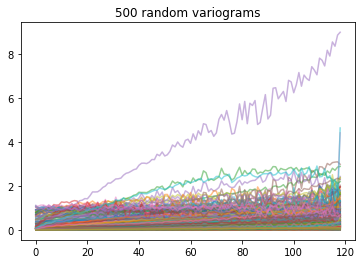

In [ ]:
n_plot= 500
plt.plot(np.transpose(generator.vg.numpy()[0:n_plot,:,0,0]), alpha=0.5);
plt.title(str(n_plot) + ' random variograms');

# Model 1

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_NV30',
    save_weights_only=False, monitor='loss', mode='min', save_best_only=True)

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(2),
])
model1.compile(optimizer= tf.keras.optimizers.Adam(), 
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history1 = model1.fit(x=generator, epochs=1000, batch_size = 200, callbacks=[checkpoint_callback], verbose=2)

Epoch 1/1000
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_NV30/assets
472/472 - 5s - loss: 0.4594 - root_mean_squared_error: 1.5505
 shuffle.
Epoch 2/1000
INFO:tensorflow:Assets written to: model_NV30/assets
472/472 - 5s - loss: 0.2525 - root_mean_squared_error: 0.3703
 shuffle.
Epoch 3/1000
INFO:tensorflow:Assets written to: model_NV30/assets
472/472 - 5s - loss: 0.2208 - root_mean_squared_error: 0.3352
 shuffle.
Epoch 4/1000
INFO:tensorflow:Assets written to: model_NV30/assets
472/472 - 5s - loss: 0.2017 - root_mean_squared_error: 0.3168
 shuffle.
Epoch 5/1000
INFO:tensorflow:Assets written to: model_NV30/assets
472/472 - 5s - loss: 0.1838 - root_mean_squared_error: 0.2974
 shuffle.
Epoch 6/1000
INFO:tensorflow:Assets written to: model_NV30/assets
472/472 - 

dict_keys(['loss', 'root_mean_squared_error'])


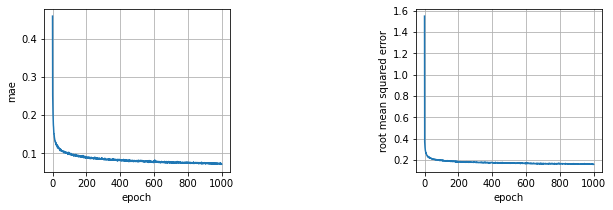

In [ ]:
print(history1.history.keys())
fig = plt.figure(figsize=(10,3))
fig.subplots_adjust(hspace=100, wspace=1)
ax1 = fig.add_subplot(1, 2, 1)      
ax1.grid()
# ax1.set_ylim([.15,.2])
ax1.plot(history1.history['loss'])
ax1.set_ylabel('mae')
ax1.set_xlabel('epoch')
ax2 = fig.add_subplot(1, 2, 2)      
# ax2.set_ylim([.25,.4])
ax2.grid()
ax2.plot(history1.history['root_mean_squared_error'])
ax2.set_ylabel('root mean squared error')
ax2.set_xlabel('epoch')
plt.show()

## Apply the model to the test data from the simulation study

In [ ]:
!wget -P npy/ https://www.dropbox.com/s/5kba6a2g777zshr/test_x.npy?dl=1
!wget -P npy/ https://www.dropbox.com/s/23goi9qyx0qpbqe/test_y.npy?dl=1
test_x = np.load('npy/test_x.npy?dl=1')
test_y = np.load('npy/test_y.npy?dl=1')

--2020-10-29 00:28:59--  https://www.dropbox.com/s/5kba6a2g777zshr/test_x.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/5kba6a2g777zshr/test_x.npy [following]
--2020-10-29 00:29:00--  https://www.dropbox.com/s/dl/5kba6a2g777zshr/test_x.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1f7e611e7924826d90a24510fb.dl.dropboxusercontent.com/cd/0/get/BCJEkyxQT0uUO0x6soSUpRJShE4qjEdbfbcKNoOSuy7moID2QEWh7zE7NDxEdvRwZTsWdkOKErZG74C7JiT9J-C-CM-Os5dGoshlYEcz5Ocv_Ni8Ap9k4qeoq6GVb_2udi4/file?dl=1# [following]
--2020-10-29 00:29:00--  https://uc1f7e611e7924826d90a24510fb.dl.dropboxusercontent.com/cd/0/get/BCJEkyxQT0uUO0x6soSUpRJShE4qjEdbfbcKNoOSuy7moID2QEWh7zE7NDxEdvRwZTsWdkOKErZG74C7JiT9J-C-CM-Os5dGoshlYEcz5Ocv_Ni8Ap9k4q

In [ ]:
## scale test_y with same transformation as used in the generator
#test_y[:,1] = np.log(test_y[:,1])
test_y_scaled = generator.scaler_y.transform(test_y)
print('test_y ---------> max: ', test_y.max(axis=0), ' mean: ', test_y.mean(axis=0), ', std: ', test_y.std(axis=0))
print('test_y_scaled --> max: ', test_y_scaled.max(axis=0), ' mean: ', test_y_scaled.mean(axis=0), ', std: ', test_y_scaled.std(axis=0))

test_y ---------> max:  [ 0.55448721 25.        ]  mean:  [-5.17562131 13.5       ] , std:  [1.81964502 6.80764402]
test_y_scaled --> max:  [ 2.07693846 -0.00692133]  mean:  [ 0.2549513  -0.80287471] , std:  [0.57858762 0.47117976]


In [ ]:
print(test_x.shape)
test_x_vg = generator.multivariofn(ims=test_x, verbose=True)
#  print(model1.evaluate(x=test_x_vg, y=test_y_scaled, verbose=0))

(10000, 16, 16, 30)
..............................

In [ ]:
vg_rep_pred = model1.predict(x=test_x_vg)
vg_rep_pred = generator.scaler_y.inverse_transform(vg_rep_pred)

In [ ]:
np.save(file='npy/test_pred_model_NV30.npy', arr=vg_rep_pred)

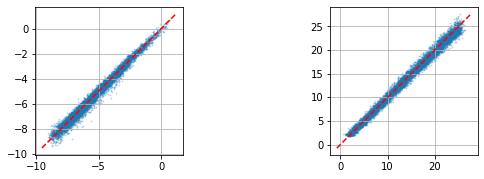

In [ ]:
def rand_jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev
def abline(ax, slope=1, intercept=0):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', c='r')
fig = plt.figure()
fig.subplots_adjust(hspace=100, wspace=1)
fig.set_size_inches(18.5, 10.5)
for i in range(2):
           ax = fig.add_subplot(1, 4, i+1)
           ax.grid()
           ax.scatter(rand_jitter(test_y[:,i]), vg_rep_pred[:,i], s=1, alpha=.2)
           ax.set_aspect('equal', 'box')
           abline(ax)

## Save model and predictions to google drive

In [ ]:
! tar -zcvf model_NV30.tar.gz model_NV30
files.download('model_NV30.tar.gz')
files.download('npy/test_pred_model_NV30.npy')
pickle.dump(generator.scaler_y, open(file='npy/scaler_y_model_NV30.pkl', mode='wb'))
files.download('npy/scaler_y_model_NV30.pkl')

model_NV30/
model_NV30/saved_model.pb
model_NV30/assets/
model_NV30/variables/
model_NV30/variables/variables.data-00000-of-00001
model_NV30/variables/variables.index


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>